# PyTorch model deployment

Making your machine deployed means making it accessible to someone or something else.

## Getting data

The dataset we are going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset from Food101 dataset, random 20% of samples

In [1]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.1.0+cu121', '0.16.0+cu121')

In [2]:
# Getting helper scripts

# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Set up device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

Compare ViT model to EffNetB2 model with the same 20% dataset (previously ViT was trained on 10% while EffNetb2 was on 20%)

In [5]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
# Set up training and test path
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## FoodVision Mini model deployment experiment outline

3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?


**FoodVision Mini ideal use case**: A model that performs well and fast.

* Performs well: 95% + accuracy
* Fast: as close to real time or faster as possible (30 fps or 30ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we will build 2 model experiments
1. EffNetB2 feature extractor
2. ViT feature extractor


## Creating an EffNetB2 feature extractor

Feature extractor is a term for a transfer learning model that has its base layers frozen and output layers/head layers customised to a certain problems.

In [7]:
import torchvision

# Bug in current torchvision version in google colab
# fix
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict
# endfix

# Setup pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # equivalent to best available

# Get EffNetB2 transform
effnetb2_transforms = effnetb2_weights.transforms()

# Create an instance of the model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Freeze base layers in model
for param in effnetb2.parameters():
  param.requires_grad = False

In [8]:
effnetb2.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
         

In [9]:
from torchinfo import summary
# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [10]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [11]:
# Set seeds
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True) # change to 3 classes
)

In [12]:
from torchinfo import summary
# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Create a function to make EffNetB2 feature extractor

In [13]:
def create_effnetb2_model(num_classes:int=3, # default classes = 3
                          seed:int=42):

  # Setup pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # equivalent to best available

  # Get EffNetB2 transform
  transforms = weights.transforms()

  # Create an instance of the model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze base layers in model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True) # change to 3 classes
  )

  return model, transforms

In [14]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [15]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

In [17]:
# Turn data into dataloaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


In [18]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## Training effnetb2 feature extractor

In [19]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)

# Training function
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


## Inspect loss curves of effnetb2


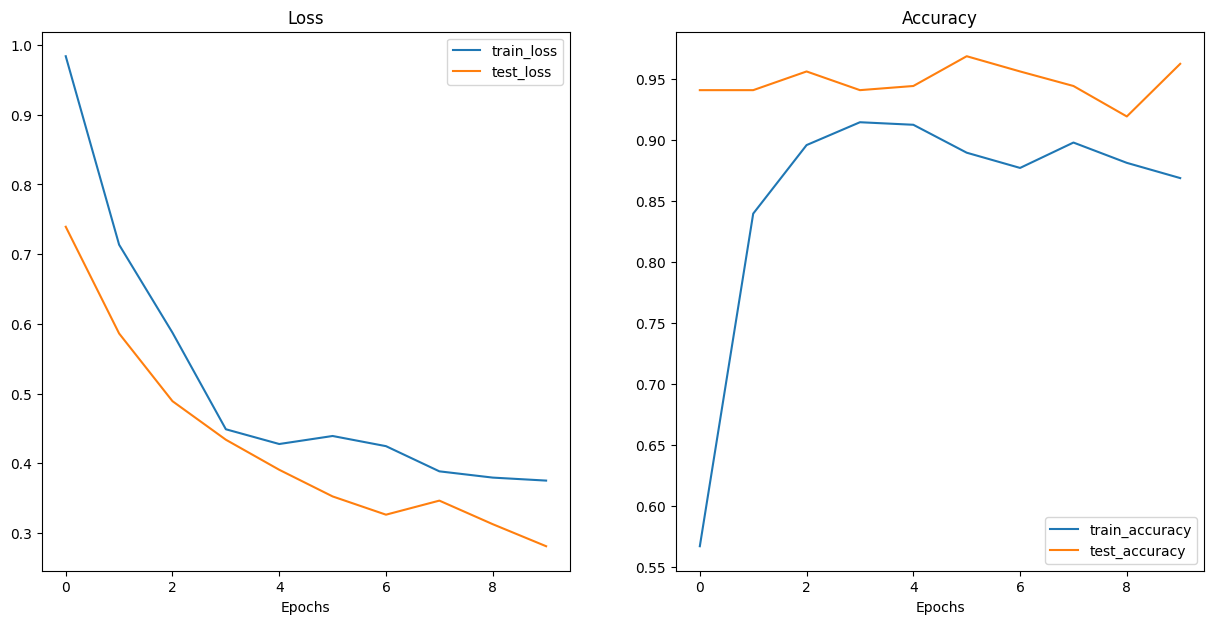

In [20]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Save EffNetB2 feature extractor to file

In [21]:
from going_modular.going_modular import utils

# Save model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## Inspecting the size of effnetb2 feature extractor

Why important to consider size of model?

If we are deploying the model to be used on a mobile app/website, there may be limited compute resources.

If model file is too large, may not be able to store/run it on target device.

In [22]:
from pathlib import Path

# Get the model size in bytes and convert to MB
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Size of EffNetB2 model: {round(pretrained_effnetb2_model_size, 2)} MB")

Size of EffNetB2 model: 29.86 MB


## Collecting EffNetB2 feature extractor stats

In [23]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters()) #numel returns the number of elements in the input tensor
effnetb2_total_params # or get from the summary

7705221

In [24]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

In [25]:
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## Now repeat the same steps for ViT feature extractor

In [26]:
# Check out heads layer of ViT
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [28]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create the weights and transforms
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()

  # Create an instance of model
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  torch.manual_seed(42)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [29]:
vit, vit_transforms = create_vit_model()

In [30]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [31]:
# Print EffNetB2 model summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Create DataLoaders for ViT feature extractor

In [32]:
# setup dataloaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## Train the ViT feature extractor

In [33]:
from going_modular.going_modular import engine
# Loss fn and optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                           lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

# Train
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## Plot loss curves for ViT feature extractor

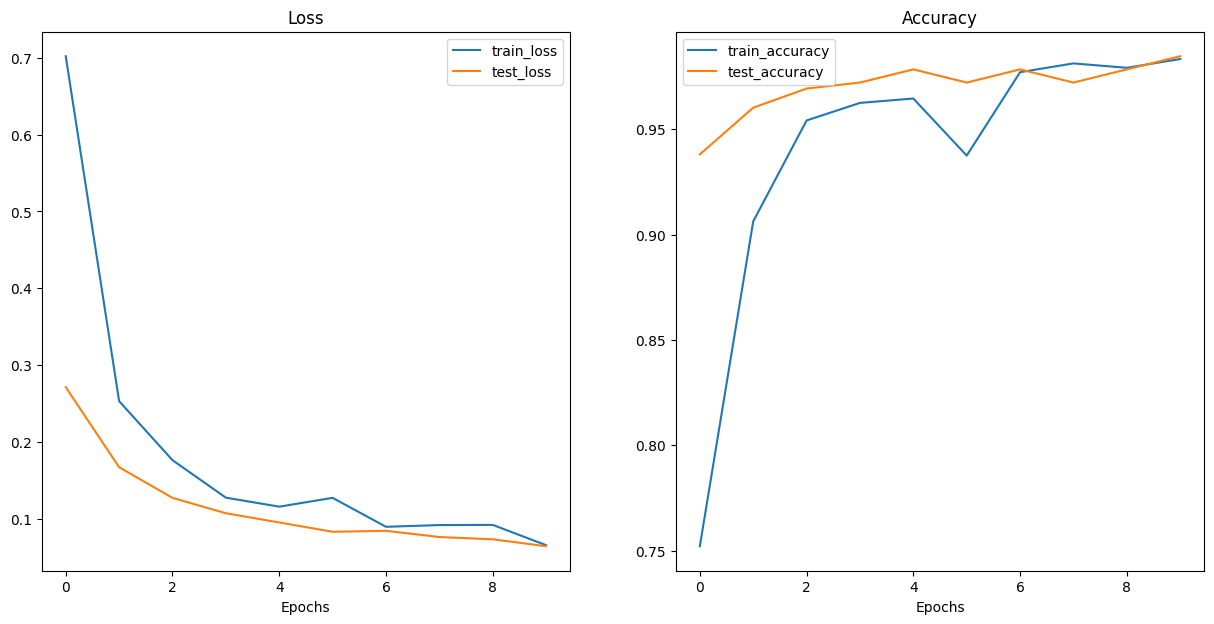

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

Can potentially experiment with data augmentation to see if improve

## Saving ViT feature extractor


In [35]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [36]:
from pathlib import Path
# Check size in MB
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Model size: {pretrained_vit_model_size:.2f} MB")

Model size: 327.37 MB


In [37]:
pretrained_effnetb2_model_size

29.8638858795166

## Collecting ViT feature extractor stats

In [38]:
# Count number of params in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [39]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}

In [40]:
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

In [41]:
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## Making predictions with trained models and timing them

Goal:
1. Performs well (95%+ accuracy)
2. Fast (30+ FPS)

To test criteria 2:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Work towards making a function `pred_and_store()`

In [42]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg')]

In [43]:
# Creating a function to make preds across the test dataset
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

# Create a function that takes a list of paths
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # Create an empty list
  pred_list = []

  # Loop through the target input paths
  for path in tqdm(paths):
    # Create an empty dict for each sample
    pred_dict = {}

    # Get sample path and ground truth path from file path
    pred_dict["image_path"] = path
    class_name = path.parent.stem # stem is the final bit
    pred_dict["class_name"] = class_name

    # Start the timer
    start_time = timer()

    # Open image using PIL.Image.open(path)
    img = Image.open(path)

    # Transform the image
    transformed_image = transform(img).unsqueeze(0).to(device) # add batch dimension (model was trained on batches)

    # Prepare for inference
    model = model.to(device)
    model.eval()

    # Turn on inference mode and perform forward pass, pred prob and pred label and pred class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # Turn logits into pred probs
      pred_label = torch.argmax(pred_prob, dim=1) # Turn pred probs into pred labels
      pred_class = class_names[pred_label.cpu()] # pred class to be on CPU (python variables live on the CPU) but out tensor was on gpu (if avail)

      # Add pred prob and pred class to empty dict
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # End timer and add time to dict
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # See if predicted class matches
    pred_dict["correct"] = class_name == pred_class

    # Append the dict to list
    pred_list.append(pred_dict)

  # Return the list
  return pred_list

In [44]:
class_names, device

(['pizza', 'steak', 'sushi'], 'cuda')

## Making and timing predictions with effnetb2

Two things to note:
1. Device - We are going to hardcore our preds to happen on CPU (not sure if we will always have GPU when you deploy your model)
2. Transforms - we want to make sure each model is predicting on images that have been prepared with the appropriate transforms (effnetB2 with `effnetb2_transforms)

In [45]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcoded on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [46]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.625,
  'pred_class': 'pizza',
  'time_for_pred': 0.1873,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9815,
  'pred_class': 'pizza',
  'time_for_pred': 0.1218,
  'correct': True}]

In [47]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd # pandas work on the cpu rather than gpu

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.6250,pizza,0.1873,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9815,pizza,0.1218,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.8625,pizza,0.1213,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5099,sushi,0.1121,False
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9874,pizza,0.0983,True


In [48]:
# Check number of correct preds
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [49]:
# Find average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
effnetb2_average_time_per_pred

0.1221

> **NOTE**: Prediction times will vary much like training times depending on the hardware you are using. Faster your computer(e.g. GPU) faster the predictions

In [50]:
# Add time per pred to effnetb2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1221}

## Making and timing predictions with ViT

In [51]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode to CPU as not sure if GPU available when deployed

  0%|          | 0/150 [00:00<?, ?it/s]

In [52]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9855,
  'pred_class': 'pizza',
  'time_for_pred': 0.6963,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9971,
  'pred_class': 'pizza',
  'time_for_pred': 0.4119,
  'correct': True}]

In [53]:
# Turn vit_test_pred_dicts into dataframes
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9855,pizza,0.6963,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9971,pizza,0.4119,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9969,pizza,0.4357,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9963,pizza,0.3984,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9938,pizza,0.4431,True


In [54]:
# See how many correct
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [55]:
# Calculate the average time per prediction for ViT
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.4633

In [56]:
# Add average time per pred to ViT stats dict
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred

In [57]:
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4633}

## Comparing model results, prediction times and size


In [58]:
# Turn stat dicts into df
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Convert accuraccy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)
# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

In [59]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1221,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4633,ViT


Which model is better?
* test_loss - ViT, lower is better
* test_acc - ViT, higher is better
* number_of_parameters (generally lower is better* for faster computing times) - EffNetB2
  * sometimes models with higher parameters can still perform fast
* model_size(MB) - EffNetB2 (for our use case of deploying to a mobile device)
* time_per_pred_cpu - lower is better, will be highly dependent on the hardware - EffNetB2

Both models fail to achieve goal of 30+FPS, we could always just try using EffNetB2 and see how it goes.

In [60]:
# Compare ViT to EffNetB2 across the different characteristics
pd.DataFrame(data = (df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962102,3.794431


## Visualise the speed vs performance tradeoff

We have compared the EffNetB2 and ViT feature extractor models, now visualise the comparison with a speed vs performance plot.

In [61]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1221,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.4633,ViT


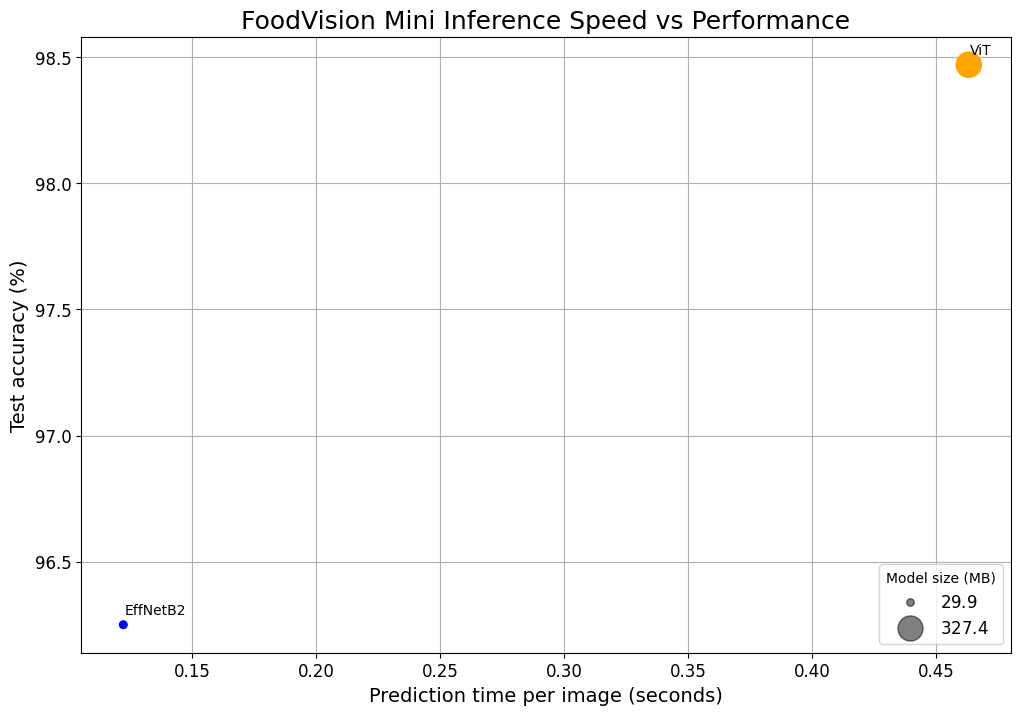

In [62]:
import matplotlib.pyplot as plt

# Create a plot from model comparision DataFrame
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],  # first model blue, second orange
                     s="model_size (MB)")

# Add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# Annotate the samples
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.04) # tuple for x, y coords
  )

# Create a legend based on model size
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

# Bringing FoodVision Mini to file by creating a Gradio demo

Chosen to deploy EffNetB2

Gradio is a fast way to deploy your model in the form of a web application.

In [63]:
# Import/install Gradio


!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0
import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 3.41.0


### Gradio Overview

Gradio helps you create machine learning demos.

Why create a demo?
So other people can try and test our models in the real-world.
Deployment is as important as training.

Overall premise of Gradio is to map inputs -> ML model -> output

Inputs and outputs can be any combination of:
text, audio, image, etc...


### Create a function to map our inputs and outputs

In [64]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu") # Hugging Face will run on the cpu (unless u pay to run on gpu)

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

# Lets create a function called `predict()` to go from:
```images of food -> ML model -> outputs (predictions, prediction_time)```

In [65]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension as the model was trained with a batch dim

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # pass transformed image through the model, and turn pred logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}


  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [66]:
class_names

['pizza', 'steak', 'sushi']

In [67]:
import random
from PIL import Image

# Get a list of all the test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg')

In [68]:
# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0] # sample returns a list
random_image_path

PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg')

In [69]:
# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg

{'pizza': 0.24345149099826813, 'steak': 0.12245986610651016, 'sushi': 0.6340886354446411}
0.108


## Creating a list of example images

In [70]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg']]

## Building a Gradio Interface

Let's use `gr.Interface()` to go from:

`input: image -> transform -> predict with effnetb2 -> output: pred, prob, time`

In [71]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images as pizza, steak or sushi"
article = "Created at [09_pytorch](https://colab.research.google.com/drive/1jzlo0ZzLQs_fij9-8bcgYqmss4i93O0W?authuser=1#scrollTo=BA3F-xB5HQt9)"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch demo
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7820816f77a409e1ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expire in 72 hours.
Host them on hugging face spaces permanently for free.

If GitHub is to showcase coding skills, Hugging Face is the platform to showcase your ML ability

### Deployed Gradio app structure

Need to put all our app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face spaces -> deploy the model
```

Our file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

You can see this in action:
* Deployed app
* See the example file structure

### Create a `demos` folder to store FoodVision Mini app files

In [72]:
import shutil # allows to do directory and file operations using python
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/foodvision_mini/

### Create a folder of example images to use with demo

What we want:
* 3 images in an `examples/` directory (one from each class)
* should be from the test set

In [73]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, # make parents dir if dont exist
                                    exist_ok=True)

# Collect 3 random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/780283.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg')]

# copy to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name # stem has no .jpg
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,        # similar to shutil.copy() but copy2 preserves the file metadata
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/780283.jpg to demos/foodvision_mini/examples/780283.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg to demos/foodvision_mini/examples/2353677.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg to demos/foodvision_mini/examples/148765.jpg


Let's verify we can get a list of lists from our examples directory

In [74]:
import os

# Get example filepaths

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2353677.jpg'], ['examples/780283.jpg'], ['examples/148765.jpg']]

## Moving our trained EffNetB2 model to FoodVision Mini demo directory

In [75]:
import shutil

# Create source file path for target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1] # remove the "models/"

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print(f"[INFO] Model move complete")

# If model has already been moved check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps it has already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete


## Turning our EffNetB2 model into a Python script (`model.py`)

We have a `.pth` model `state_dict` and want to load it into a model instance.

Let's move our create_effnetb2_model function into a script

In [76]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default classes = 3
                          seed:int=42):

  # Setup pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # equivalent to best available

  # Get EffNetB2 transform
  transforms = weights.transforms()

  # Create an instance of the model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze base layers in model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True) # change to 3 classes
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [77]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` will have 4 major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [78]:
%%writefile demos/foodvision_mini/app.py

### Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model # model.py is going to be in the same directory as app.py
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### Model and transforms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3
)

# Load the saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth", # app.py living in the same directory
        map_location=torch.device("cpu") # hardcoded to cpu (since model trained on gpu it may think to load back to gpu when loading)
    )
)

### Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension as the model was trained with a batch dim

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # pass transformed image through the model, and turn pred logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}


  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images as pizza, steak or sushi"
article = "Created at [09_pytorch](https://colab.research.google.com/drive/1jzlo0ZzLQs_fij9-8bcgYqmss4i93O0W?authuser=1#scrollTo=BA3F-xB5HQt9)"


# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]
# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch demo
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL


Writing demos/foodvision_mini/app.py


## requirements.txt tells Hugging Face what software dependencies it has to install

The three main ones are:
* torch
* torchvision
* gradio

In [79]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.1.0
torchvision==0.16.0
gradio==3.41.0

Writing demos/foodvision_mini/requirements.txt


In [80]:
torch.__version__

'2.1.0+cu121'

In [81]:
torchvision.__version__

'0.16.0+cu121'

In [82]:
gr.__version__

'3.41.0'

## Deploying our FoodVision Mini app in Hugging Face Spaces

can use web interface / command line

### Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face space

In [83]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   __pycache__
examples								   requirements.txt


In [84]:
# Change into the foodvision_mini directory and then zip it from the inside
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*" # zip commands in linux

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/2353677.jpg (deflated 0%)
  adding: examples/780283.jpg (deflated 1%)
  adding: examples/148765.jpg (deflated 0%)
  adding: model.py (deflated 47%)
  adding: requirements.txt (deflated 8%)


In [85]:
!pwd # print working dir

/content


In [86]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")

except:
  print(f"Not runnning in Google Colab, can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Running our FoodVision Mini demo locally

If you download the `foodvision_mini.zip` file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
5. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
    * **Note:** This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade `pip` first: `pip install --upgrade pip`.
6. Run the app (`python3 app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.

> **Note:** If you run the app locally and you notice a `flagged/` directory appear, it contains samples that have been "flagged".
>
> For example, if someone tries the demo and the model produces an incorrect result, the sample can be "flagged" and reviewed for later.
>
> For more on flagging in Gradio, see the [flagging documentation](https://gradio.app/docs/#flagging).

## Uploading our FoodVision Mini Gradio demo to Hugging Face spaces


### Uploading to Hugging Face

We've verfied our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face.

> **Note:** The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the [Git and GitHub for Beginners tutorial](https://youtu.be/RGOj5yH7evk) on freeCodeCamp.

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Mini Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_mini` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!


And we can even embed our FoodVision Mini Gradio demo into our notebook as an [iframe](https://gradio.app/sharing_your_app/#embedding-with-iframes) with [`IPython.display.IFrame`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.IFrame) and a link to our space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

##[Deployed model on Hugging Spaces](https://huggingface.co/spaces/purplelord2003/foodvision_mini)

In [87]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://huggingface.co/embed/purplelord2003/foodvision_mini/+", width=900, height=750)

## Creating FoodVision Big

FoodVision Mini works well with 3 classes (pizza, steak, sushi)

Step up to using all of the Food101 classes

## Create model for FoodVision Big + transforms

In [88]:
#
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [89]:
from torchinfo import summary
# Print EffNetB2 model summary
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [90]:
# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## If we train on larger datasets, our model may overfit (learn too much into the training set) so we can try using data augmentation to increase generalisation
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, lets use trivial augment as our data augmentation technique.


In [94]:
# Create a new transform
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

## Get data for FoodVision Big

In [95]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # apply data augmentation to training data
                              download=True)


# Get testing data (~250 x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # dont perform data augmentation on the testing data
                             download=True)

100%|██████████| 4996278331/4996278331 [04:48<00:00, 17322114.31it/s]


Extracting data/food-101.tar.gz to data


In [96]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Create a subset of the Food101 dataset for faster experimenting

We want our first few experiments to run as quick as possible.

This is the first time we have upgraded to 101 classes

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test)

Our short term goal: to beat the original Food101 paper result of 56.40% accuracy for test dataset

We want to beat this result using modern deep learning techniques and only 20% of the data

In [97]:
len(train_data), len(test_data)

(75750, 25250)

In [98]:
0.2 * len(train_data), 0.2 * len(test_data)

(15150.0, 5050.0)

In [99]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2 # will return a tuple

In [100]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(train_data, # only interested in the first split
                                                 split_size=0.2)


# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(test_data, # only interested in the first split
                                                 split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [101]:
len(train_data_food101_20_percent)

15150

In [102]:
len(test_data_food101_20_percent)

5050

## Turning food101 dataset into dataloders

In [103]:
import torch
import os

NUM_WORKERS = os.cpu_count()

BATCH_SIZE = 32

# Create Food101 training dataloader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 testing dataloader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [106]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent) # number of batches

(474, 158)

## Training FoodVision BIG

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

Things for training:
* 5 epochs
* Optimizer: torch.optim.Adam(lr=1e-3)
* Loss fn: torch.nn.CrossEntropyLoss(label_smoothing=0.1)

Why use label smoothing?
* Regularisation technique to prevent overfitting

Without label smoothing and 5 classes:
```
[0.00, 0.00, 0.99, 0.01, 0.00]
```
Can become overconfident on one particular class


With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```
Helps to decrease the overconfidence (consider the other classes a bit more)


In [107]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101's paper result of 56.4% accuracy with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


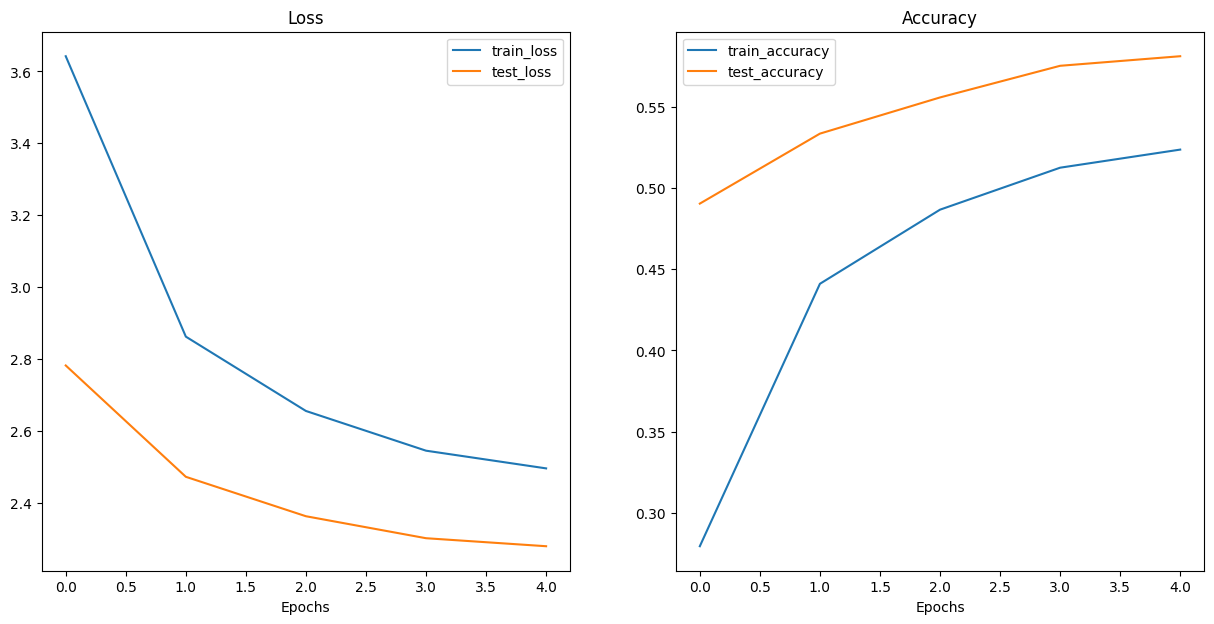

In [108]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [109]:
## Save and load FoodVision Big model

from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [110]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

In [114]:
loaded_effnetb2_food101

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Checking FoodVision Big model size


In [117]:
from pathlib import Path

# Get model size in bytes and convert to MB
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30.38140296936035 MB


Only slightly larger than FoodVision Mini since only last classification layer was changed

## Turning FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world.

Create outline for FoodVision Big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [119]:
from pathlib import Path

# Create Foodvision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True,
                                                  exist_ok=True)


## Downloading an example image and moving it to the `examples` directory

In [120]:
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [134]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Collect more random test dataset image paths
foodvision_big_examples = [Path('data/food-101/images/chocolate_cake/1001084.jpg'),
                            Path('data/food-101/images/chicken_wings/1003533.jpg'),
                            Path('data/food-101/images/pancakes/1006982.jpg'),
                           Path('data/food-101/images/hot_dog/103364.jpg')]

# copy to the examples directory
for example in foodvision_big_examples:
  destination = Path('demos/foodvision_big/examples/')
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,        # similar to shutil.copy() but copy2 preserves the file metadata
               dst=destination)

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2024-01-29 08:18:45--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.009s  

2024-01-29 08:18:45 (301 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]

[INFO] Copying data/food-101/images/chocolate_cake/1001084.jpg to demos/foodvision_big/examples
[INFO] Copying data/food-101/images/chicken_wings/1003533.jpg to demos/foodvision_big/examples
[INFO] Copying data/food-101/images/pancakes/1006982.jpg to demos/foodvision_big/examples
[INFO] Copying data/food-101/images/hot_dog/103364.jpg to demos/foodvision_big/examples
mv: cannot 

## Saving Food101 class names to file (`class_names.txt`)

We can simply make the list within app.py but 101 classes are too many so it is neater to make a txt file to import in afterwards into app.py

Lets save all the class names to .txt file so we can import them into our app

In [124]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

In [127]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # join all items in an iterable "\n" is the separator -> new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [128]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()] # strip removes spaces(including /n) at the beginning and after the string
food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Turning FoodVision Big model into Python script (`model.py`)

In [130]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default classes = 3
                          seed:int=42):

  # fix
  from torchvision.models._api import WeightsEnum
  from torch.hub import load_state_dict_from_url

  def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
  WeightsEnum.get_state_dict = get_state_dict
  # endfix

  # Setup pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # equivalent to best available

  # Get EffNetB2 transform
  transforms = weights.transforms()

  # Create an instance of the model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze base layers in model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True) # change to 3 classes
  )

  return model, transforms

Writing demos/foodvision_big/model.py


## Turning FoodVision Big Gradio app into a python script (`app.py`)
1. Imports and class names setup - this time import the class names from `class_names.txt`
2. Model and transforms prep
3. Predict function
4. Gradio app interface + launch

In [132]:
%%writefile demos/foodvision_big/app.py
### Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth", # same file level as app.py
               map_location=torch.device("cpu")) # Hugging Face spaces free tier offers cpu
)

### Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # add batch dimension as the model was trained with a batch dim

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # pass transformed image through the model, and turn pred logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}


  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### Gradio app ###
title = "FoodVision Big 🍕🥩🍣🧁🌮🧇"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify [101 classes of food](https://github.com/purplelord2003/PyTorch/raw/main/class_names.txt)"
article = "Created at [09_pytorch](https://colab.research.google.com/drive/1jzlo0ZzLQs_fij9-8bcgYqmss4i93O0W?authuser=1#scrollTo=BA3F-xB5HQt9)"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]
# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch demo
demo.launch(debug=False) # print errors locally?

Writing demos/foodvision_big/app.py


## Creating requirements.txt for FoodVision Big

In [133]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.1.0
torchvision==0.16.0
gradio==3.41.0

Writing demos/foodvision_big/requirements.txt


## Download FoodVision Big app files

In [135]:
# Change into the foodvision_bug directory and then zip it from the inside
# Change into and then zip the foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*" # zip commands in linux

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 51%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/1006982.jpg (deflated 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: examples/103364.jpg (deflated 0%)
  adding: examples/1003533.jpg (deflated 0%)
  adding: examples/1001084.jpg (deflated 2%)
  adding: model.py (deflated 51%)
  adding: requirements.txt (deflated 8%)


In [137]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")

except:
  print(f"Not runnning in Google Colab, can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Deploying our FoodVision Big model app to Hugging Face spaces

Let's bring FoodVision Big to life by deploying it

Deployed model:
https://huggingface.co/spaces/purplelord2003/foodvision_big